In [1]:
# read j3 wrf ts files

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd
plots_dir = nb_dir[0]+'/plots_03a'

# time step of wrf runs
d02_wrf_dt = 10
d04_wrf_dt = 0.4

# tower location & domain number to analyze
sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 'les': ['c1.d04', d04_wrf_dt]}

# les averaging time
les_avg_time = '15Min'

# exclude les spin up time
les_spinup = np.timedelta64(1, 'h')

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# obs
dlprofwind_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
dlprofwstats_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

dlprofwind = xr.open_mfdataset(dlprofwind_ncs)
dlprofwstats = xr.open_mfdataset(dlprofwstats_ncs)

# according to Rob Newsom, lidar data taken < 100 m need to be thrown out
toss_wp_data_below_height = 100

# vertical profile plot top height threshold
profile_hgt_thres = 2000

# plotting variables
dlprofwind_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
dlprofwstats_dict = {'w': ['w', r'w (m s$^{-1}$)']}

In [4]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):

    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height)).values)
    
    return [x for x in wp_height_list if str(x) != 'nan']

def read_wp_wrf_1day(obs, eval_date, row): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    wrf_meso_dir = wrf_runs_dir+date_col[row]+'/'
    c1_meso_file_path = wrf_meso_dir+'z_ts/z.'+sim_dict['meso'][0]
    meso_tower = Tower(c1_meso_file_path)
    
    wrf_les_dir = wrf_runs_dir+date_col[row]+'/'
    c1_les_file_path = wrf_les_dir+'z_ts/z.'+sim_dict['les'][0]
    les_tower = Tower(c1_les_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_meso_ds = read_tower_to_ds(meso_tower, wrf_start, sim_dict['meso'][1], wrf_height_list)
    wrf_les_ds = read_tower_to_ds(les_tower, wrf_start, sim_dict['les'][1], wrf_height_list)

    return obs_ds, wrf_meso_ds, wrf_les_ds

def plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units, freq, wrf_std_ds=None): 
    
    ts_lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    # reverse height list, useful for plotting
    wp_height_list = get_wp_height_list(wp_ds)[:len(ts_lc_list)][::-1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for hgt, lc in enumerate(ts_lc_list): 

        # slice of data at each height
        wrf_1height = wrf_ds.sel(height=wp_height_list[hgt])
        wp_1height = wp_ds.sel(height=wp_height_list[hgt])

        ax[0].plot(wrf_1height['datetime'], wrf_1height[wrf_var], 
                 label=str(np.round(wrf_1height['height'].values).astype(int))+' m', 
                 c=lc, linewidth=lw)
        ax[0].plot(wp_1height['time'], wp_1height[wp_var], c=lc, linewidth=lw, linestyle='--')
        
        if wrf_std_ds is not None: 
            
            wrf_std_1height = wrf_std_ds.sel(height=wp_height_list[hgt])
            
            ax[0].fill_between(wrf_std_1height['datetime'], 
                               wrf_1height[wrf_var].squeeze()+wrf_std_1height[wrf_var].squeeze(), 
                               wrf_1height[wrf_var].squeeze()-wrf_std_1height[wrf_var].squeeze(), 
                               alpha=0.1)

    ax[0].tick_params(labelrotation=90)
    # 24 hours of data in plot
    ax[0].set_xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    ax[0].set_xlabel('UTC time (Z)')
    ax[0].set_ylabel(var_units)
    ax[0].legend(title=wrf_run)

    wrf_synctime = wrf_ds.sel(datetime=freq, method='nearest')
    wp_synctime = wp_ds.sel(time=freq, method='nearest')

    wrf_hgt_top_i = (wrf_synctime['height'] < profile_hgt_thres).sum().values
    wp_hgt_top_i = (wp_synctime['height'] < profile_hgt_thres).sum().values
    
    profile_lc = list(mcolors.TABLEAU_COLORS)

    for ind, time_i in enumerate(list(range(len(wp_synctime['time']))[0::8])): 

        wrf_time = wrf_synctime['datetime'][time_i].values.astype('datetime64[s]').tolist()

        ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                   wrf_synctime['height'][:wrf_hgt_top_i], 
                   c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        ax[1].plot(wp_synctime[wp_var][time_i, :wp_hgt_top_i], 
                   wp_synctime['height'][:wp_hgt_top_i], 
                   linestyle='--', c=profile_lc[ind])
        
        if wrf_std_ds is not None: 
            
            wrf_std_synctime = wrf_std_ds.sel(datetime=freq, method='nearest')
            
            ax[1].fill_betweenx(
                wrf_synctime['height'][:wrf_hgt_top_i],
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]\
                +wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]\
                -wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                                
                   color=profile_lc[ind], alpha=0.1)

    ax[1].set_ylabel('Height AGL (m)')
    ax[1].set_xlabel(var_units)
    ax[1].legend(title=wrf_run)
    
    plt.suptitle(wp_var+': '+wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)

    plt.savefig(plots_dir+'/ts_prof_'+eval_date+'_'+wp_var+'_'+wrf_run+'.pdf')
    
    plt.show()
    plt.close(fig)

def plot_taydiag(obs, eval_date, row): 
    
    obs_ds, wrf_meso_ds, wrf_les_ds = read_wp_wrf_1day(obs, eval_date, row)

#     wrf_dict = {row: wrf_meso_ds, row+'-les': wrf_les_ds}

    # get start & end time to trim time series
    time_start = np.max([wrf_meso_ds['datetime'].min().values, wrf_les_ds['datetime'].min().values, 
                         obs_ds['time'].min().values]) + les_spinup
    time_end = np.min([wrf_meso_ds['datetime'].max().values, wrf_les_ds['datetime'].max().values, 
                       obs_ds['time'].max().values])

    # start w/ obs
    time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

    wrf_les_ds_cut = wrf_les_ds.sel(datetime=slice(time_start, wrf_les_ds['datetime'].max().values))

    wrf_les_ds_mean = wrf_les_ds_cut.resample(datetime=les_avg_time).mean()
    wrf_les_ds_std = wrf_les_ds_cut.resample(datetime=les_avg_time).std()

    # refer to the most infrequent data series
    # need matching time dimension to calculate correlation, etc. 
    for model in [wrf_meso_ds, wrf_les_ds]: 

        model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

        if len(time_freq) > len(model_time_freq): 

            time_freq = model_time_freq

    obs_height_list = get_wp_height_list(obs_ds)

    # taylor diagram for the 1st height
    lev_i = 0

    obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
    wrf_meso_slice = wrf_meso_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
    wrf_les_mean_slice = wrf_les_ds_mean.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')

    if obs.platform_id == 'dlprofwind4news': 
        var_dict = dlprofwind_dict
    if obs.platform_id == 'dlprofwstats4news': 
        var_dict = dlprofwstats_dict
    
    for wrf_var, var in var_dict.items():

        print('######################################################################')

    #         for wrf_run, wrf_ds in wrf_dict.items(): 

        plot_wp_ts_profile(eval_date, row, wrf_meso_ds, obs_ds, wrf_var, var[0], var[1], time_freq)
        plot_wp_ts_profile(eval_date, row+'-les', wrf_les_ds_mean, obs_ds, wrf_var, var[0], var[1], 
                           time_freq, wrf_les_ds_std)

        models = {}
        models['meso'] = wrf_meso_slice[wrf_var]
        models['les'] = wrf_les_mean_slice[wrf_var]

        fig = plt.figure(figsize=(8, 8))
        td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                           srange=(0, 1.6), extend=False,
                           corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                           #minorcorrticks=np.arange(0.05,0.9,0.1),
                           #stdevticks=np.arange(0.2,2,0.2),
                           labelsize='x-large')

        for name, series in models.items():
            corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
            R2 = corr_xy**2
            stdev = series.std().values
            # print(name, stdev, R2)
            td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

        td.add_grid()

        contours = td.add_contours(levels=15, colors='0.5')
        plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

        fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
                   numpoints=1, prop=dict(size='medium'), loc='upper right')

        hgt_str = str(np.round(obs_slice['height'].values).astype(int))

        plt.title(var[0]+' @ '+hgt_str+' m: '+eval_date)

        plt.savefig(plots_dir+'/taydiag_'+eval_date+'_'+var[0]+'_'+hgt_str+'m_'+row+'.pdf')

        plt.show()
        plt.close('all')

    del(obs_ds, wrf_meso_ds, wrf_les_ds)
    
    return obs_slice, wrf_meso_slice, wrf_les_mean_slice

######################################################################


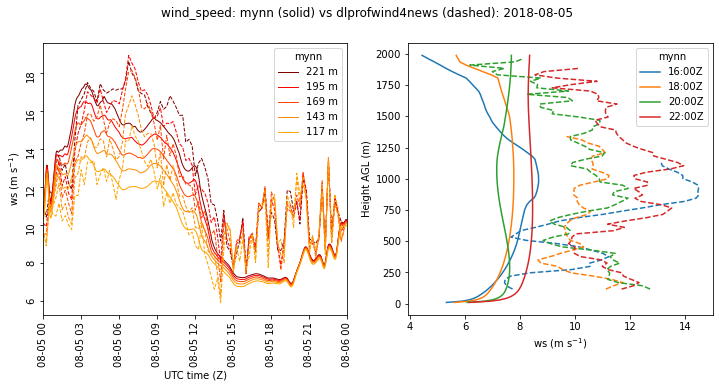

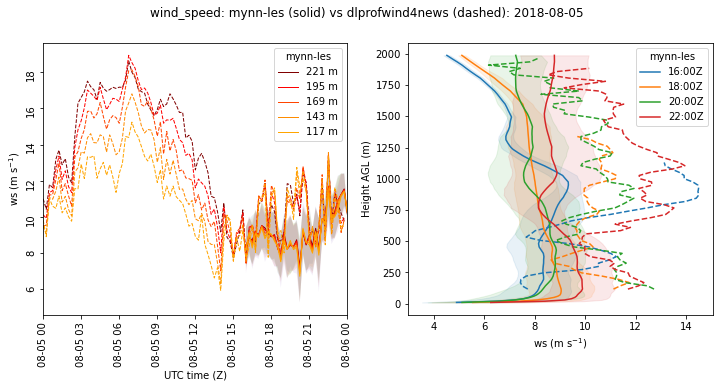

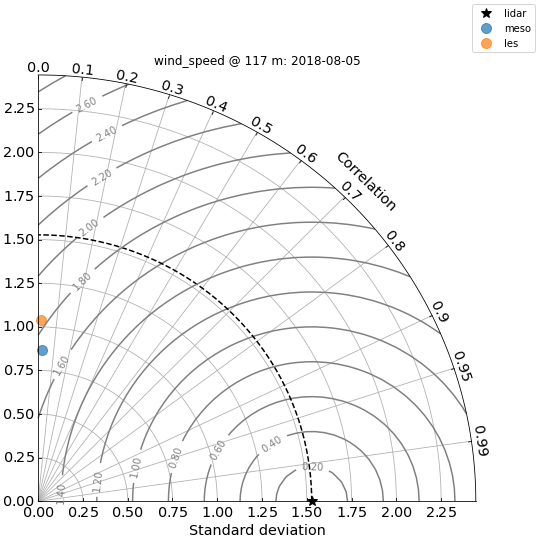

######################################################################


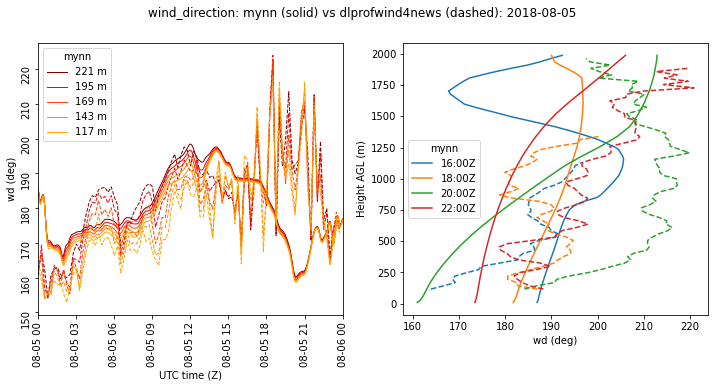

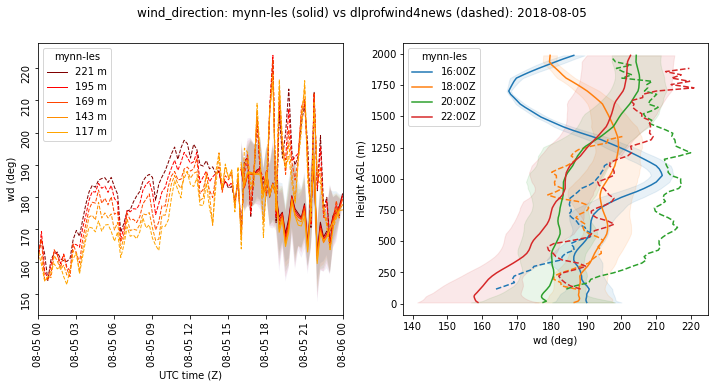

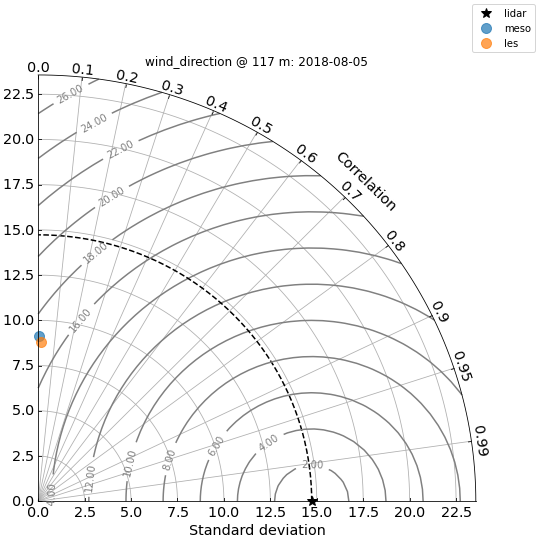

######################################################################


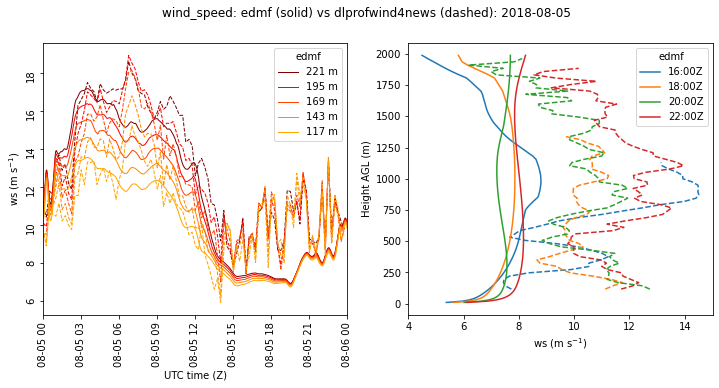

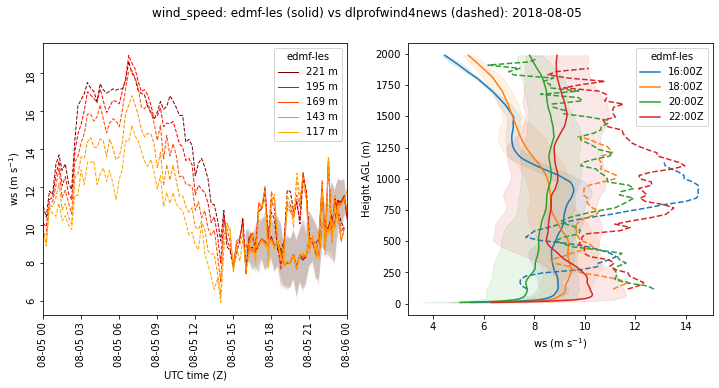

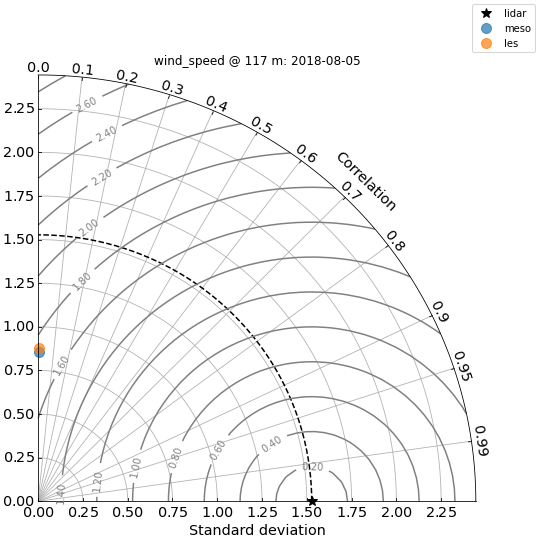

######################################################################


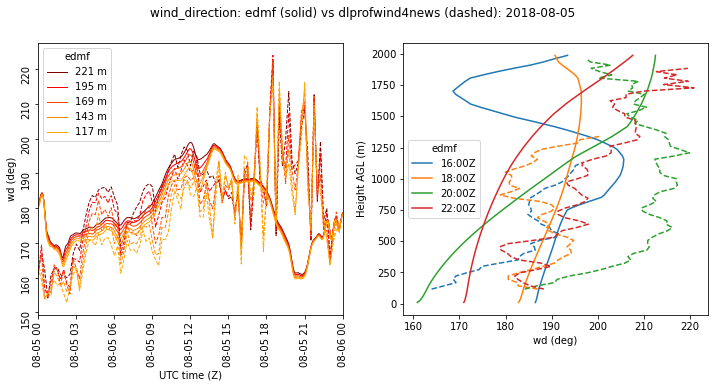

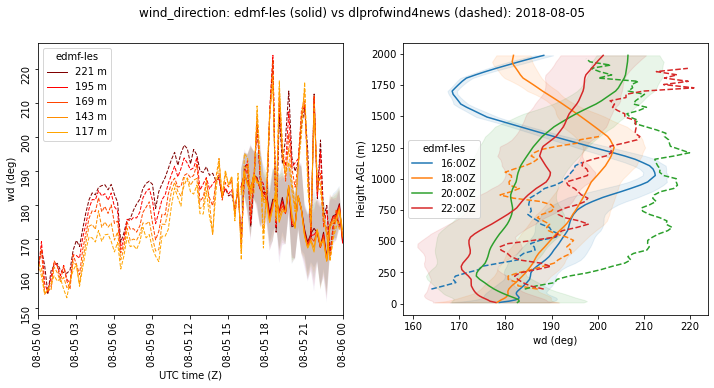

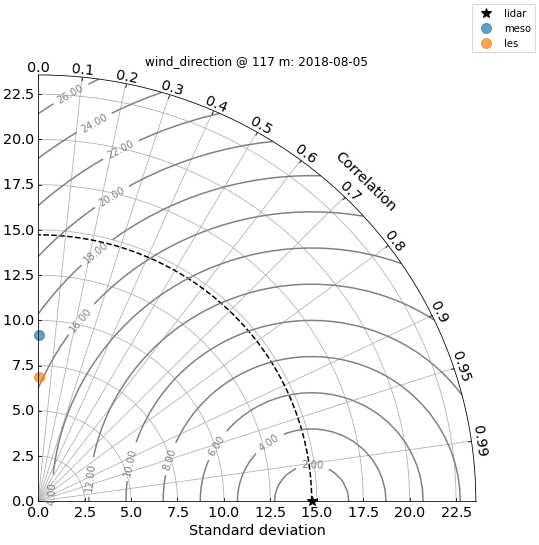

######################################################################


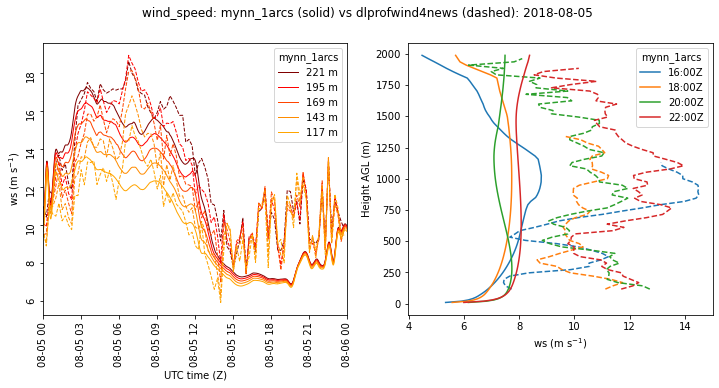

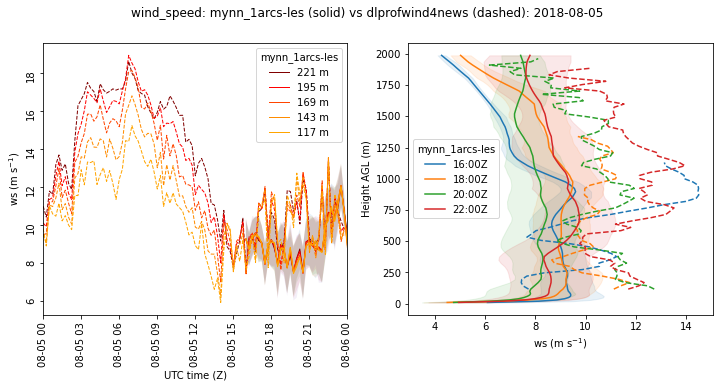

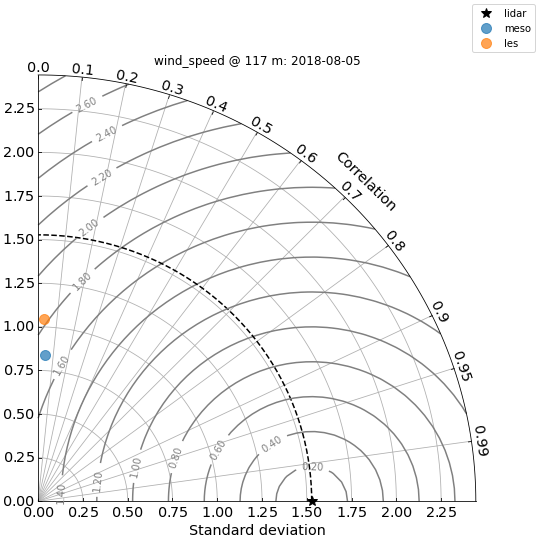

######################################################################


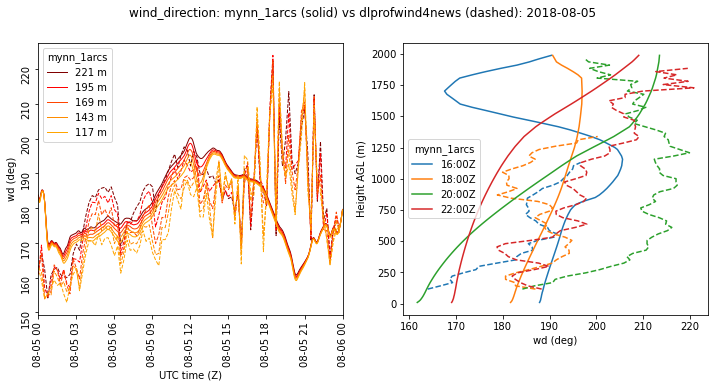

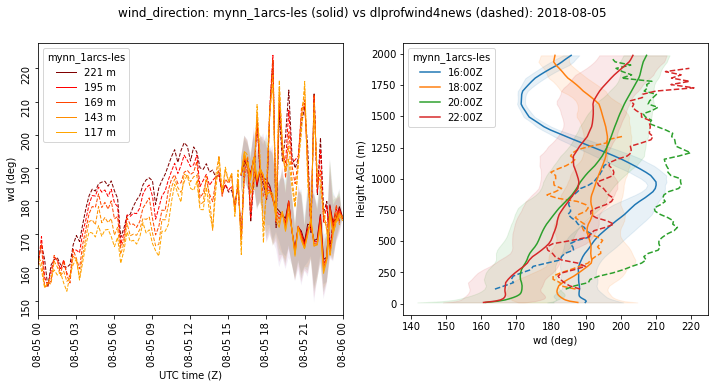

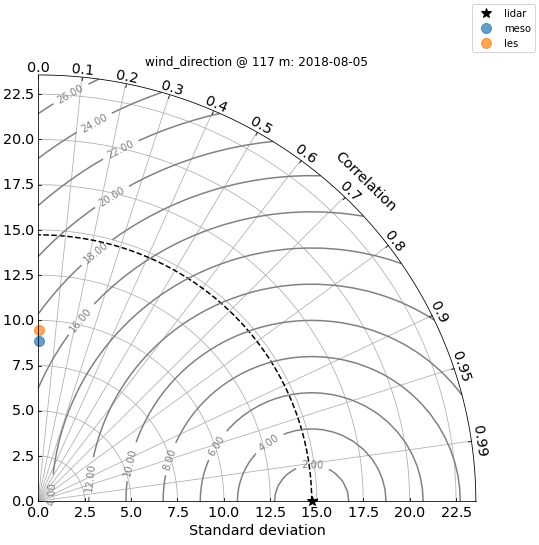

In [3]:
eval_date = '2018-08-05'
for row in ['mynn', 'edmf', 'mynn_1arcs']: 
    plot_taydiag(dlprofwind, eval_date, row)

######################################################################


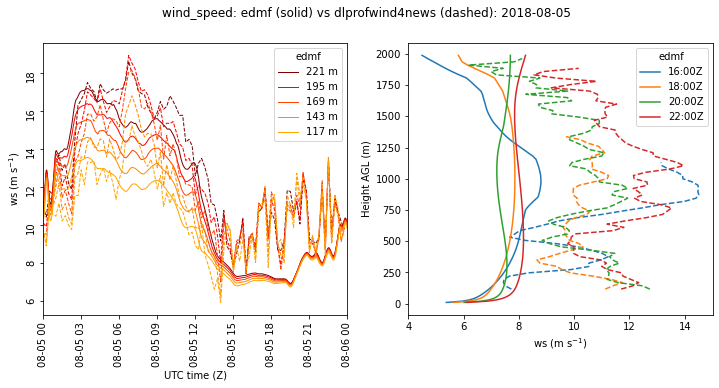

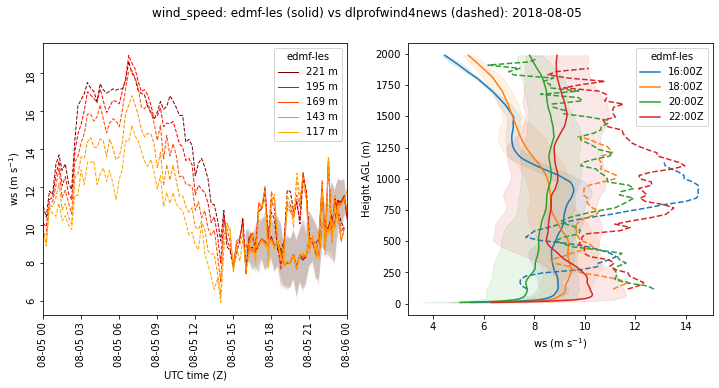

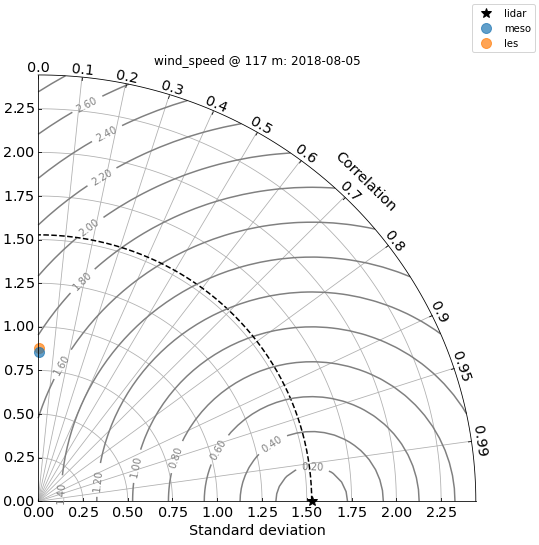

######################################################################


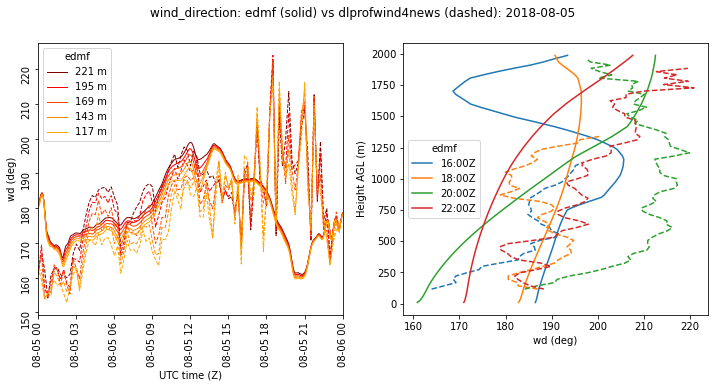

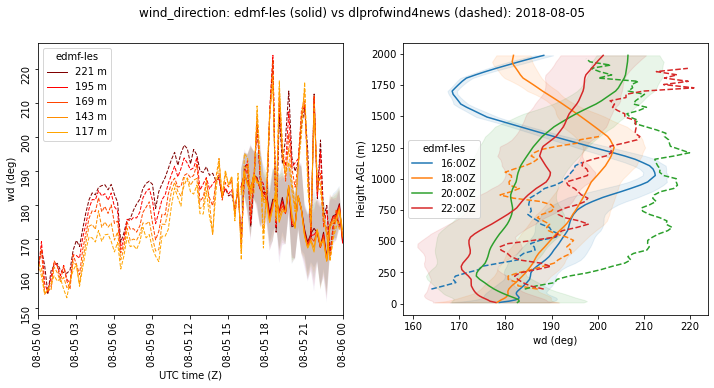

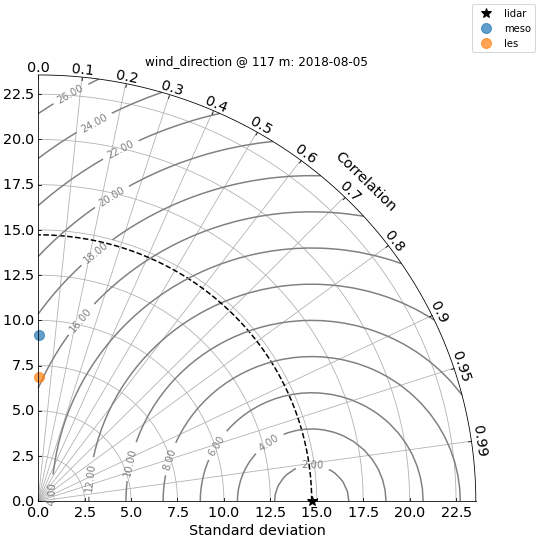

In [5]:
oe, we, wlese = plot_taydiag(dlprofwind, eval_date, 'edmf')

######################################################################


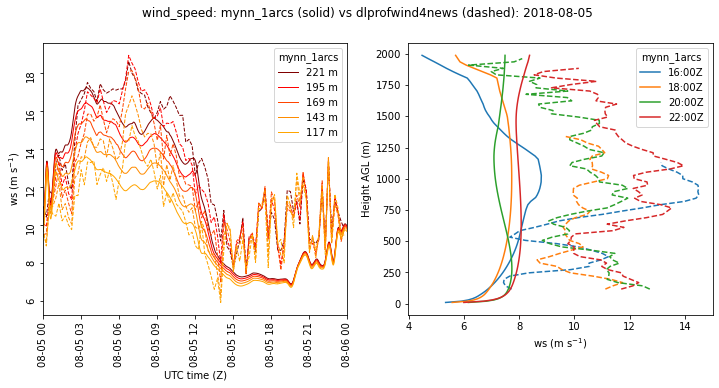

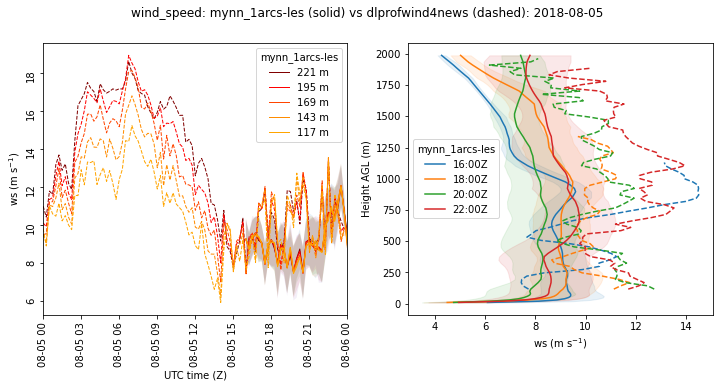

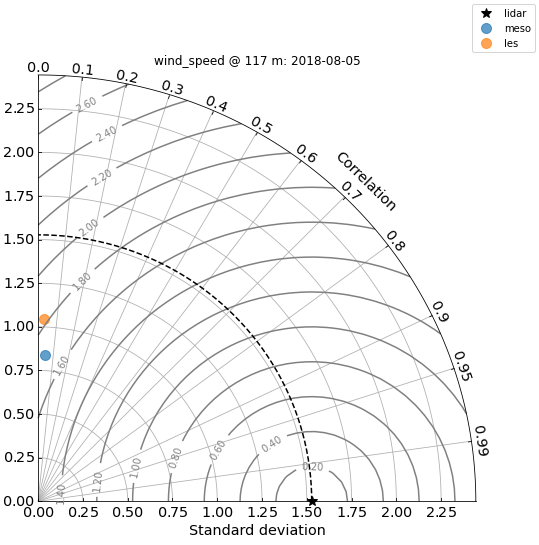

######################################################################


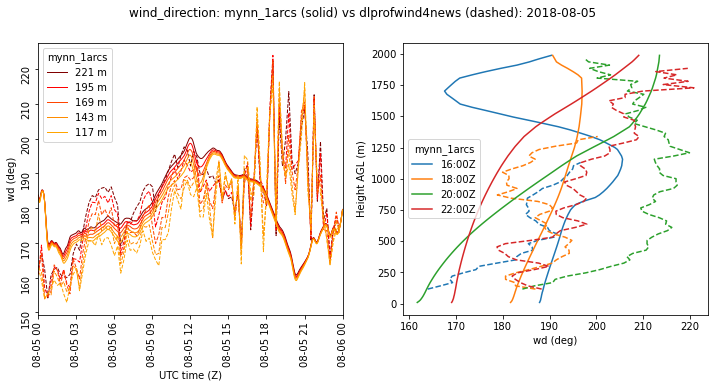

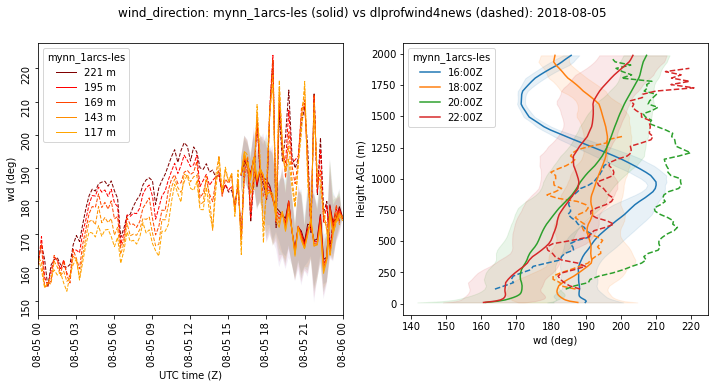

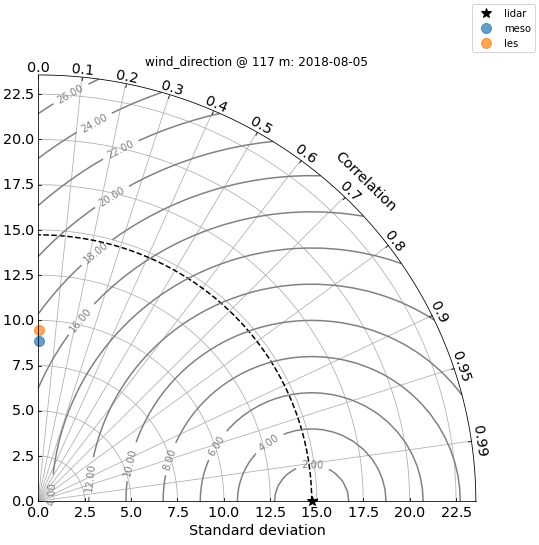

In [7]:
om, w1e, wles1e = plot_taydiag(dlprofwind, eval_date, 'mynn_1arcs')

In [33]:
np.squeeze(oe['wind_speed']).values.std()

1.5273968

In [32]:
np.squeeze(we['ws']).values.std()

0.853191837307604

In [34]:
np.squeeze(wlese['ws']).values.std()

0.8808008151930804

In [31]:
np.corrcoef((np.squeeze(we['ws']).values, np.squeeze(oe['wind_speed']).values))**2

array([[1.        , 0.00814354],
       [0.00814354, 1.        ]])

In [36]:
np.sqrt(((np.squeeze(we['ws']).values - np.squeeze(oe['wind_speed']).values)**2).mean())

2.9551600073511253

In [37]:
np.sqrt(((np.squeeze(wlese['ws']).values - np.squeeze(oe['wind_speed']).values)**2).mean())

2.103895965306161

In [30]:
np.corrcoef((np.squeeze(wlese['ws']).values, np.squeeze(oe['wind_speed']).values))**2

array([[1.        , 0.00360295],
       [0.00360295, 1.        ]])